In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from IPython.display import Image
import pandas as pd
from functools import reduce
!pip install xgboost
from xgboost import XGBClassifier
from tqdm import tqdm
# Plot inline
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('MBA.csv')
df = df.drop('application_id',axis=1)
df['international'] = df['international'].map({False: 0, True: 1})
df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})
df['admission'].fillna('Deny', inplace=True)
factor = pd.factorize(df['admission'])
df.admission = factor[0]
definitions = factor[1]

df = pd.get_dummies(df, columns=['major', 'race', 'work_industry'])
df.head()

,gender,international,gpa,gmat,work_exp,admission,major_Business,major_Humanities,major_STEM,race_Asian,...,work_industry_Health Care,work_industry_Investment Banking,work_industry_Investment Management,work_industry_Media/Entertainment,work_industry_Nonprofit/Gov,work_industry_Other,work_industry_PE/VC,work_industry_Real Estate,work_industry_Retail,work_industry_Technology
0,1,0,3.30,620.0,3.0,0,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,0,0,3.28,680.0,5.0,1,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
2,1,1,3.30,710.0,5.0,0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,0,0,3.47,690.0,6.0,1,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
4,0,0,3.35,590.0,5.0,1,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df_train_noWoE, df_test_noWoE = train_test_split(df, # Data
                                                             test_size = 0.3,           # Size of test
                                                             random_state = 42)   # Seed

In [ ]:
#Define the classifier.
XGB = XGBClassifier(max_depth=5,                 # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='multi:softmax',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=2,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=1,                  # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=42         # Seed
                            )

In [ ]:
# Define the parameters. Play with this grid!
param_grid = dict({'n_estimators': [5, 7, 10, 15, 20, 30, 40, 50, 100, 150, 200],
                   'max_depth': [1,2, 3,4,5,6,7,8,9,10],
                 'learning_rate' : [0.001,0.005, 0.01,0.05, 0.1],
                  'subsample' :[0.6,0.7,0.8,0.9,1],                  # Subsample ratio. Can set lower
                  'colsample_bytree':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                  'colsample_bylevel':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                  'colsample_bynode':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                  })

In [ ]:
# Always a good idea to tune on a reduce sample of the train set, as we will call many functions.
val_train = df_train_noWoE.sample(frac = 0.3,               # The fraction to extract
                                       random_state = 42    # The seed.
                                       )

In [ ]:
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, precision_score, recall_score,classification_report, accuracy_score
f1_scorer = make_scorer(precision_score, average='weighted')  # Since high class imbalance, we don't want to use accuracy
GridXGB = GridSearchCV(XGB,        # Original XGB.
                        param_grid=param_grid, scoring=f1_scorer, cv=5, verbose=2, n_jobs=-1)

In [ ]:
print(param_grid)

{'n_estimators': [5, 7, 10, 15, 20, 30, 40, 50, 100, 150, 200], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1], 'subsample': [0.6, 0.7, 0.8, 0.9, 1], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'colsample_bynode': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}


In [ ]:
GridXGB.fit(val_train, val_train['admission'])

Fitting 5 folds for each of 2750000 candidates, totalling 13750000 fits


KeyboardInterrupt: 

In [ ]:
GridXGB.best_params_

In [ ]:
# Create XGB with best parameters.
XGB = XGBClassifier(max_depth=GridXGB.best_params_.get('max_depth'), # Depth of each tree
                            learning_rate=GridXGB.best_params_.get('learning_rate'), # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=GridXGB.best_params_.get('n_estimators'), # How many trees to use, the more the better, but decrease learning rate if many used.
                            objective='multi:softmax',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=2,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=1,                  # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=.33,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=42         # Seed
                            )

In [ ]:
param_grid = dict({
                  'subsample' :[0.4,0.5,0.6],                  # Subsample ratio. Can set lower
                  'colsample_bytree': [0.4,0.5,0.6],
                  'colsample_bylevel': [0.6,0.7,0.8],
                  'colsample_bynode': [0.6,0.7,0.8],
                  })

In [ ]:
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, precision_score, recall_score,classification_report, accuracy_score
f1_scorer = make_scorer(precision_score, average='weighted')  # Since high class imbalance, we don't want to use accuracy
GridXGB = GridSearchCV(XGB,        # Original XGB.
                        param_grid=param_grid, scoring=f1_scorer, cv=5, verbose=2, n_jobs=-1)

In [ ]:
GridXGB.fit(val_train, val_train['admission'])

In [ ]:
GridXGB.best_params_

In [ ]:
# Create XGB with best parameters.
XGB = XGBClassifier(max_depth=2, # Depth of each tree
                            learning_rate=0.05, # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=200, # How many trees to use, the more the better, but decrease learning rate if many used.
                            objective='multi:softmax',  # multiclass
                            booster='gbtree',             # boosing trees
                            subsample=0.6,colsample_bytree=0.6,colsample_bylevel=.8, colsample_bynode=0.7,
                            random_state=42
                            )

In [ ]:
XGB = XGBClassifier(max_depth=2,
                            learning_rate=0.05,
                            n_estimators=200,
                            objective='multi:softmax',
                            booster='gbtree',
                            subsample=0.6,colsample_bytree=0.6,colsample_bylevel=.8, colsample_bynode=0.7,
                            random_state=42
                            )

In [ ]:
x= df_train_noWoE.drop('admission',axis=1)
y= df_train_noWoE['admission']
XGB.fit(x,y)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=0.7, colsample_bytree=0.6,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

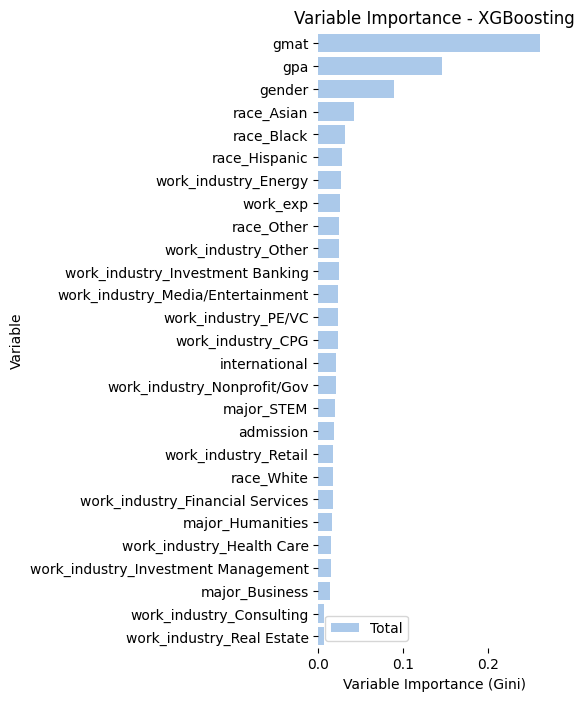

In [ ]:
# Plot variable importance
importances = XGB.feature_importances_
indices = np.argsort(importances)[::-1]

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[df_train_noWoE.columns[i] for i in indices], x=importances[indices],
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)

In [ ]:
# prompt: get classification_report of my XGBoost model

from sklearn.metrics import classification_report

x_test = df_test_noWoE.drop('admission', axis=1)
y_test = df_test_noWoE['admission']

y_pred = XGB.predict(x_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.540     0.090     0.155       299
           1      0.831     0.986     0.902      1525
           2      0.000     0.000     0.000        35

    accuracy                          0.823      1859
   macro avg      0.457     0.359     0.352      1859
weighted avg      0.768     0.823     0.765      1859



In [ ]:
probTest = XGB.predict_proba(bankloan_test_noWoE.iloc[:, :-1])
probTest = probTest[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(bankloan_test_noWoE['Default'],
                                 probTest)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = bankloan_test_noWoE['Default'],
                             y_score = probTest),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()